#Modifying IOTA 6-6 lattice for chromaticity tests

First step - look @ the `lattice_2IO_chrome.madx` file showing full chromaticity correction. Evaluate what specific sextupoles are used to to adjust chromaticity.

Next step - play around with the `adjust_chromaticities` command to produce lattices (based on the bare uncorrected lattice) with desired chromaticities using a subset of thes sextupoles being used for complete correction.

Final step - optimize this procedure to construct a lattice with equal chromaticities and minimal total sextupole strengths.

In [90]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import sys, os
import synergia
from mpi4py import MPI
import synergia_workflow
import scipy

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from elliptic import EllipticBeam6D
from base_diagnostics import lfplot
from base_diagnostics import latticework

In [92]:
lattice = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_2IO_chrome.madx")
lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_2IO.madx")


#for elem in lattice.get_elements():
#    elem.set_string_attribute("extractor_type", "chef_propagate")
      
nsteps_per_element = 10
nsteps = len(lattice.get_elements())*nsteps_per_element
        
name = 'lattice_2IO_chrome'
order = 1
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
opts.macro_particles=1000
#opts.emitx = 1.0e-5
workflow.make_path(outputdir)


stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
lattice_simulator2 = stepper2.get_lattice_simulator()

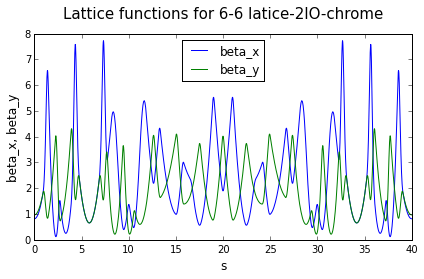

In [93]:
from base_diagnostics import lfplot
from base_diagnostics import options

popts = options.Options()
popts.lattice_name = '6-6 latice-2IO-chrome'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False


lfplot.plot_sliced_lattice_functions(popts)

In [94]:
cy = lattice_simulator.get_vertical_chromaticity()
cx = lattice_simulator.get_horizontal_chromaticity()

In [95]:
print cx, cy

-0.0463982468796 0.882817976265


In [96]:
cy_orig = lattice_simulator2.get_vertical_chromaticity()
cx_orig = lattice_simulator2.get_horizontal_chromaticity()

In [97]:
print cx_orig, cy_orig

-10.3867216476 -6.06407866369


##Basic Chromaticity Correction

Let's examine how easily one could do chromaticity correction. A quick note on lattice differentiation:

- lattice - the chromaticity corrected 6-6 IOTA lattice with 2 IO sections - lattice_2IO_chrome
- lattice2 - the standard IOTA 6-6 lattice with 2 IO sections - lattice_2IO
- adjusted_lattice - the standard IOTA 6-6 lattice with 2 IO sections, with new target chromaticities

A good question to be asked would be: "Which sextupoles are being used for correction in the corrected (chrome) lattice?". It probably makes sense to only vary those sextupoles to remain consistent with the design approach of the IOTA 6-6 lattice.

####Determine which sextupoles are being adjusted for the chromaticity corrected lattice

In [20]:
#All we need to do is grab the lattice elements from the chromaticitiy corrected lattice and check strengths
p_six_c, n_six_c = latticework.get_sextupoles(lattice)
for ele in n_six_c:
    print "{}: {}".format(ele.get_name(),ele.get_double_attribute("k2"))
for ele in p_six_c:
    print "{}: {}".format(ele.get_name(),ele.get_double_attribute("k2"))

sc1r: -378.7028064
se1r: 0.0
se2l: 0.0
sd1l: 0.0
sc1l: -378.7028064
sc2r: 754.9476289
sd1r: 0.0
se2r: 0.0
se1l: 0.0
sc2l: 754.9476289


Only the elements "sc1r", "sc1l", "sc2r", and "sc2l" are being used. We will add their names to a list to be referenced for constructing the list for the "adjusted lattice."

**NOTE: I NEED TO RE-ARRAGE THINGS. MY "GET_SEXTUPOLES" SCRIPT IS RETURNING 0 STRENGTH ELEMENTS ARBITRARILY BETWEEN P_SIX AND N_SIX. A better approach would be to construct entirely new lists from the lattice.**

In [34]:
p_six_use = [ele.get_name() for ele in p_six_c if ele.get_double_attribute("k2") > 0]
n_six_use = [ele.get_name() for ele in n_six_c if ele.get_double_attribute("k2") < 0]

In [38]:
print p_six_use

['sc2r', 'sc2l']


In [51]:
print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in p_six]
print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in n_six]

['sc1r: -80.534054861', 'sd1r: 0.0', 'se1l: 0.0', 'sc2l: 247.600843941']
['sc2r: 247.600843941', 'se1r: 0.0', 'sd1l: 0.0', 'sc1l: -80.534054861']


In [50]:
print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in p_six_c]
print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in n_six_c]

['sc2r: 754.9476289', 'sd1r: 0.0', 'se2r: 0.0', 'se1l: 0.0', 'sc2l: 754.9476289']
['sc1r: -378.7028064', 'se1r: 0.0', 'se2l: 0.0', 'sd1l: 0.0', 'sc1l: -378.7028064']


####Now implement a basic chromaticity correction to the uncorrected lattice using only the sextupoles specified by the previous analysis.

In [98]:
## Quickly construct lattice simulator

from base_diagnostics import workflow
from base_diagnostics import latticework


#Get the uncorrected lattice!
adjusted_lattice_simulator = stepper2.get_lattice_simulator()
adjusted_lattice = adjusted_lattice_simulator.get_lattice()

cy_orig = adjusted_lattice_simulator.get_vertical_chromaticity()
cx_orig = adjusted_lattice_simulator.get_horizontal_chromaticity()

cx_goal = cy_orig
cy_goal = cy_orig

c_tol = 1.0e-5; #need to define a tolerance for the fit


#grab the sextupoles which are being used (nonzero) in the chromaticity corrected lattice
p_six_c, n_six_c = latticework.get_sextupoles(lattice)
p_six_use = [ele.get_name() for ele in p_six_c if ele.get_double_attribute("k2") > 0]
n_six_use = [ele.get_name() for ele in n_six_c if ele.get_double_attribute("k2") < 0]

#print the original strengths of the things that will be adjusted
#print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in p_six_c]
#print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in n_six_c]

#grab the sextupoles from the adjusted lattice
#p_six, n_six = latticework.get_sextupoles(adjusted_lattice)

#filter to make sure we only keep the ones that we want to adjust
p_s = [ele for ele in adjusted_lattice.get_elements() if ele.get_name() in p_six_use]
n_s = [ele for ele in adjusted_lattice.get_elements() if ele.get_name() in n_six_use]

#use these magnets to adjust the chromaticity
adjusted_lattice_simulator.adjust_chromaticities(cx_goal,cy_goal,p_s,n_s,c_tol)

#update the lattice
adjusted_lattice_simulator.update()
adjusted_lattice = adjusted_lattice_simulator.get_lattice()

#Force define original lattice simulator
lattice2 = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_2IO.madx")
stepper2 = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
lattice_simulator2 = stepper2.get_lattice_simulator()


#Print stuff for original lattice
print "Original horizontal chromaticity: {}".format(lattice_simulator2.get_horizontal_chromaticity())
print "Original vertical chromaticity: {}".format(lattice_simulator2.get_vertical_chromaticity())

#print the original strengths of the things that will be adjusted
p_six_orig, n_six_orig = latticework.get_sextupoles(lattice2)
latticework.print_strengths(p_six_orig, False)
latticework.print_strengths(n_six_orig, False)

print ""
#Print stuff for new re-tuned lattice
print "New horizontal chromaticity: {}".format(adjusted_lattice_simulator.get_horizontal_chromaticity())
print "New vertical chromaticity: {}".format(adjusted_lattice_simulator.get_vertical_chromaticity())
p_six_new, n_six_new = latticework.get_sextupoles(adjusted_lattice)
latticework.print_strengths(p_six_new, False)
latticework.print_strengths(n_six_new, False)
#print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in p_six_new]
#print [": ".join([ele.get_name(), str(ele.get_double_attribute("k2"))]) for ele in n_six_new]

Original horizontal chromaticity: -10.3867216476
Original vertical chromaticity: -6.06407866369
sc1r K2: 0.0
sd1r K2: 0.0
se1l K2: 0.0
sc2l K2: 0.0
sc2r K2: 0.0
se1r K2: 0.0
sd1l K2: 0.0
sc1l K2: 0.0

New horizontal chromaticity: -6.06407882028
New vertical chromaticity: -6.06407889777
sc2r K2: 247.600843941
sd1r K2: 0.0
se1l K2: 0.0
sc2l K2: 247.600843941
sc1r K2: -80.534054861
se1r K2: 0.0
sd1l K2: 0.0
sc1l K2: -80.534054861


Now we see if the lattice retains its nice symmetries.

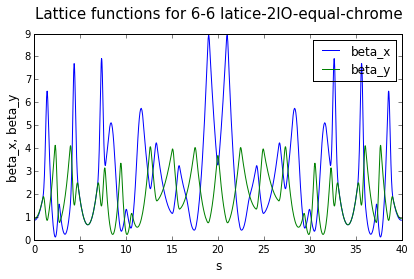

In [73]:
from base_diagnostics import lfplot
from base_diagnostics import options

popts = options.Options()
popts.lattice_name = '6-6 latice-2IO-equal-chrome'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
popts.lattice_simulator = adjusted_lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = adjusted_lattice

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False


lfplot.plot_sliced_lattice_functions(popts)

###Optimization of the chromaticity "adjusted" lattice by minimization of the sextupole strengths

Our goal is to construct a lattice with equal vertical and horizontal chromaticities. To preserve dynamic aperture, we'd also like to minimize the strengths in the sextupoles. To that end, I will implement the chromaticity correciton capabilities of Synergia as depicted above, but wrapped in a cost minimization algorithm, which attempts to minimize the sum of the (absolute value) sextupoles strengths.

**Approach**
    - Make a guess of an optimum $C_x$ value
    - Require $C_x$ = $C_y$
    - Adjust lattice to fulfill this condition
    - Calculate cost function
    - Iterate until convergence to some minimum

In [149]:
#First wrap the synergia function in a way that allows passage to a minimizer.

def chromaticity_adjust(l_s, p_list, n_list, C0):
    '''
        -lattice - synergia lattice
        -p_list - list of positive sextupole lattice element names which should be varied
        -n_list - list of negative sextupole lattice element names which should be varied 
        -C0 - a value for C_x, C_y we want to reach
        
        DEPRECTATED:
            -p_s - list of positive-valued sextupoles to adjust
            -n_s - list of negative-values sextupoles to adjust
    '''
    
    c_tol = 1.e-3
    cx_goal = C0
    cy_goal = C0
    
    #make sure we grab the correct elements to adjust
    lattice = l_s.get_lattice()
    p_s = [ele for ele in lattice.get_elements() if ele.get_name() in p_list]
    n_s = [ele for ele in lattice.get_elements() if ele.get_name() in n_list]
    
    #adjust the chromaticity
    l_s.adjust_chromaticities(cx_goal,cy_goal,p_s,n_s,c_tol)
    
    c_final = l_s.get_vertical_chromaticity()
    print 'Adjusted chromaticity to new value: {}'.format(c_final)
    print ''
    
    #calculate Cost function
    cost = 0
    cost += np.sum([np.abs(ele.get_double_attribute('k2')) for ele in p_s]) #add p_s contributions
    cost += np.sum([np.abs(ele.get_double_attribute('k2')) for ele in n_s]) #add n_s contributions
    
    print 'Calculated Cost Function: {}'.format(cost)
    
    return cost

In [100]:
#grab the sextupoles which are being used (nonzero) in the chromaticity corrected lattice
p_six_c, n_six_c = latticework.get_sextupoles(lattice)
p_six_use = [ele.get_name() for ele in p_six_c if ele.get_double_attribute("k2") > 0]
n_six_use = [ele.get_name() for ele in n_six_c if ele.get_double_attribute("k2") < 0]

p_s = [ele for ele in lattice2.get_elements() if ele.get_name() in p_six_use]
n_s = [ele for ele in lattice2.get_elements() if ele.get_name() in n_six_use]

In [116]:
cgoal = -9.
chromaticity_adjust(lattice_simulator2,p_six_use, n_six_use,cgoal)

Adjusted chromaticity to new value: -8.99999072753

Calculated Cost Function: 155.879138106


155.87913810575336

In [118]:
cgoal = -8.6
chromaticity_adjust_fixed(cgoal)

Adjusted chromaticity to new value: -8.59999537131

Calculated Cost Function: 173.180690831


173.18069083072555

In [117]:
#Define this function with fixed lattice and element lists - e.g. as a scalar function of one variable.
def chromaticity_adjust_fixed(C0, lattice_simulator=lattice_simulator2 , p_list=p_six_use, n_list=n_six_use):
    '''
        -lattice - synergia lattice
        -p_list - list of positive sextupole lattice element names which should be varied
        -n_list - list of negative sextupole lattice element names which should be varied 
        -C0 - a value for C_x, C_y we want to reach
        
        DEPRECTATED:
            -p_s - list of positive-valued sextupoles to adjust
            -n_s - list of negative-values sextupoles to adjust
    '''
    
    c_tol = 1.e-5
    cx_goal = C0
    cy_goal = C0
    
    #make sure we grab the correct elements to adjust
    lattice = lattice_simulator.get_lattice()
    p_s = [ele for ele in lattice.get_elements() if ele.get_name() in p_list]
    n_s = [ele for ele in lattice.get_elements() if ele.get_name() in n_list]
    
    #adjust the chromaticity
    lattice_simulator.adjust_chromaticities(cx_goal,cy_goal,p_s,n_s,c_tol)
    
    c_final = lattice_simulator.get_vertical_chromaticity()
    print 'Adjusted chromaticity to new value: {}'.format(c_final)
    print ''
    
    #calculate Cost function
    cost = 0
    cost += np.sum([np.abs(ele.get_double_attribute('k2')) for ele in p_s]) #add p_s contributions
    cost += np.sum([np.abs(ele.get_double_attribute('k2')) for ele in n_s]) #add n_s contributions
    
    print 'Calculated Cost Function: {}'.format(cost)
    
    return cost

In [120]:
scipy.optimize.minimize_scalar(chromaticity_adjust_fixed, bounds = (-10., -6.), method='Bounded')

Adjusted chromaticity to new value: -8.47213435705

Calculated Cost Function: 181.2961541
Adjusted chromaticity to new value: -7.52786436337

Calculated Cost Function: 251.349703862
Adjusted chromaticity to new value: -9.05572774138

Calculated Cost Function: 171.29606523
Adjusted chromaticity to new value: -8.99337420689

Calculated Cost Function: 154.047562498
Adjusted chromaticity to new value: -8.77913184645

Calculated Cost Function: 161.811215576
Adjusted chromaticity to new value: -8.91154371397

Calculated Cost Function: 153.407438981
Adjusted chromaticity to new value: -8.94070520076

Calculated Cost Function: 151.556494527
Adjusted chromaticity to new value: -8.94956514876

Calculated Cost Function: 150.993987596
Adjusted chromaticity to new value: -8.96629410061

Calculated Cost Function: 149.932084674
Adjusted chromaticity to new value: -8.97663804783

Calculated Cost Function: 149.418154933
Adjusted chromaticity to new value: -8.98303095081

Calculated Cost Function: 151.1

  status: 0
    nfev: 26
 success: True
     fun: 149.30245688143401
       x: -8.9762190706295133
 message: 'Solution found.'

In [124]:
print "New horizontal chromaticity: {}".format(lattice_simulator2.get_horizontal_chromaticity())
print "New vertical chromaticity: {}".format(lattice_simulator2.get_vertical_chromaticity())
p_six_new, n_six_new = latticework.get_sextupoles(lattice2)
latticework.print_strengths(p_six_new, False)
latticework.print_strengths(n_six_new, False)

New horizontal chromaticity: -8.97621565299
New vertical chromaticity: -8.97621531642
sc1r K2: 74.65089429
sc2r K2: 0.000428880551584
sd1r K2: 0.0
se1l K2: 0.0
sc2l K2: 0.000428880551584
sc1l K2: 74.65089429
se1r K2: 0.0
sd1l K2: 0.0


We immediately notice that the sextupole strength for the sc2 elements is extremely small. One wonders what the difference might be by simply removing this element!

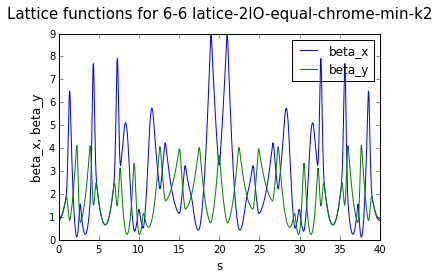

In [125]:
from base_diagnostics import lfplot
from base_diagnostics import options

popts = options.Options()
popts.lattice_name = '6-6 latice-2IO-equal-chrome-min-k2'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
popts.lattice_simulator = lattice_simulator2
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = lattice2

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False


lfplot.plot_sliced_lattice_functions(popts)

####Check the result from removing the sc2 pair of sextupoles

If we can obtain reasonable results simply from adjusting the sc1 pair of sextupoles, then there could be real savings in operational expenses (and simplification of the lattice dynamics) by doing so. We will test this by setting these sextupole values to 0 and then double checking.

In [167]:
#Force define original lattice simulator
base_lattice = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/lattices/Iota6-6/lattice_2IO.madx")
base_stepper = synergia.simulation.Independent_stepper_elements(lattice2, opts.map_order, opts.steps_per_element)
base_lattice_simulator = base_stepper.get_lattice_simulator()

In [170]:
p_six_use_1 = ['sc1r','sc1l']
n_six_use_1 = []

for ele in base_lattice.get_elements():
    if ele.get_name() in p_six_use_1:
        ele.set_double_attribute('k2',74.65089429)

base_lattice_simulator.update()

In [173]:
print "New horizontal chromaticity: {}".format(base_lattice_simulator.get_horizontal_chromaticity())
print "New vertical chromaticity: {}".format(base_lattice_simulator.get_vertical_chromaticity())
p_six_check, n_six_check = latticework.get_sextupoles(base_lattice)
latticework.print_strengths(p_six_check, False)
latticework.print_strengths(n_six_check, False)

New horizontal chromaticity: -8.97631994212
New vertical chromaticity: -8.97599999989
sc1r K2: 74.65089429
sc2r K2: 0.0
se1r K2: 0.0
sd1l K2: 0.0
sc1l K2: 74.65089429
sd1r K2: 0.0
se1l K2: 0.0
sc2l K2: 0.0


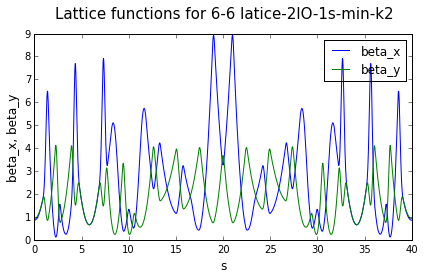

In [174]:
from base_diagnostics import lfplot
from base_diagnostics import options

popts = options.Options()
popts.lattice_name = '6-6 latice-2IO-1s-min-k2'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = True
popts.variance = 0.5
popts.lattice_simulator = base_lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y']
popts.lattice = base_lattice

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False


lfplot.plot_sliced_lattice_functions(popts)

In [172]:
print "New horizontal chromaticity: {}".format(lattice_simulator.get_horizontal_chromaticity())
print "New vertical chromaticity: {}".format(lattice_simulator.get_vertical_chromaticity())
p_six_corr, n_six_corr = latticework.get_sextupoles(lattice)
latticework.print_strengths(p_six_corr, False)
latticework.print_strengths(n_six_corr, False)

New horizontal chromaticity: -0.0463982468796
New vertical chromaticity: 0.882817976265
sc2r K2: 754.9476289
sd1r K2: 0.0
se2r K2: 0.0
se1l K2: 0.0
sc2l K2: 754.9476289
sc1r K2: -378.7028064
se1r K2: 0.0
se2l K2: 0.0
sd1l K2: 0.0
sc1l K2: -378.7028064


###Output the various corrected/test lattices to madx files

It seems like a good idea to be able to save these lattice files so I don't have to run the adjustment scripts every time! However I'm not sure I know how to write this stufff directly to madx. One thing I could do is write whatever output I can to a .txt file in a specific folder in the lattices folder, and then manually adjust the base lattice.

In [67]:
def write_to_madx(lattice, infile, outfile):
    '''
    Construct a new madx file describing an adjusted Synergia lattice by modifying an original inputfile.
    
    Arguments:
        -lattice - The Synergia lattice with properties that you should be saved
        -infile - The original MADX file which was used to generate the lattice
        -outfile - The new MADX file which will contain the adjusted elements
    
    Notes:
        -This function currently only adjusts element strengths - It won't insert elements or change reference particles
    
    '''
    
    
    
    

###Verify that when I load up the lattices I modified, I get the correct thing

In [175]:
import_lattice = synergia.lattice.MadX_reader().get_lattice("iota", "/Users/ncook/Synergia_Tests/IOTA6-6_Chromaticity_Tests/2I_approx_equal_chrome_mink1/lattice_2IO_1s_approx.madx")
import_stepper = synergia.simulation.Independent_stepper_elements(import_lattice, opts.map_order, opts.steps_per_element)
import_lattice_simulator = import_stepper.get_lattice_simulator()

In [176]:
print "New horizontal chromaticity: {}".format(import_lattice_simulator.get_horizontal_chromaticity())
print "New vertical chromaticity: {}".format(import_lattice_simulator.get_vertical_chromaticity())
p_six_imp, n_six_imp = latticework.get_sextupoles(import_lattice)
latticework.print_strengths(p_six_imp, False)
latticework.print_strengths(n_six_imp, False)

New horizontal chromaticity: -8.97622577651
New vertical chromaticity: -8.97620987453
sc1r K2: 74.65089429
sc2r K2: 0.0
se1r K2: 0.0
sd1l K2: 0.0
sc1l K2: 74.65089429
sd1r K2: 0.0
se1l K2: 0.0
sc2l K2: 0.0


We still have agreement to 5 significant digits in the chromaticities, as desired.

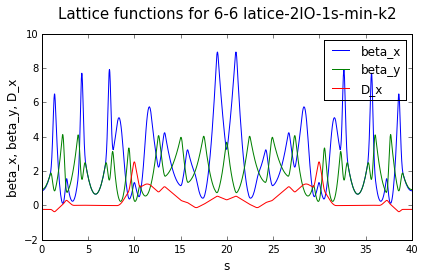

In [179]:
from base_diagnostics import lfplot
from base_diagnostics import options

popts = options.Options()
popts.lattice_name = '6-6 latice-2IO-1s-min-k2'
popts.ID = None
popts.path = None
popts.turns = opts.turns 
popts.norm = False
popts.save = False
popts.variance = 0.5
popts.lattice_simulator = base_lattice_simulator
popts.relpath = opts.output_dir
popts.lf_fns = ['beta_x','beta_y','D_x']
popts.lattice = base_lattice

popts.plots = ['x','y']
popts.num = 1
popts.scale = 2
popts.plot_lost = False


lfplot.plot_sliced_lattice_functions(popts)

The lattice functions look good as well. We have equal chromaticities and zero dispersion through the NL drifts, and thus the lattice satisfies the two requirements specified in Stephen's paper.